<a href="https://colab.research.google.com/github/NajouaMardi/sentiment-analysis/blob/master/app/MI_And_LogisticR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer


In [16]:
df = pd.read_csv('processed_reviews_100k_cleaned.csv')
df.head()

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment,label_match
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative,True
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive,True
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive,True
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive,True
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive,True


In [17]:
print("shape ",df.shape)
print("checking if data is missing",df.isnull().sum())
print("data types of columns",df.dtypes)

shape  (99708, 10)
checking if data is missing rating               0
title                0
text                 0
timestamp            0
helpful_vote         0
verified_purchase    0
label                0
full_text            0
sentiment            0
label_match          0
dtype: int64
data types of columns rating               float64
title                 object
text                  object
timestamp              int64
helpful_vote           int64
verified_purchase      int64
label                 object
full_text             object
sentiment             object
label_match             bool
dtype: object


In [18]:
#Summary statistics for numeric columns
df.describe()

,rating,timestamp,helpful_vote,verified_purchase
count,99708.000000,9.970800e+04,99708.000000,99708.000000
mean,3.819914,1.487554e+12,3.697798,0.947065
std,1.491207,9.132823e+10,19.713274,0.223904
min,1.000000,9.517750e+11,0.000000,0.000000
25%,3.000000,1.423705e+12,0.000000,1.000000
50%,5.000000,1.482899e+12,0.000000,1.000000
75%,5.000000,1.560087e+12,2.000000,1.000000
max,5.000000,1.679170e+12,2091.000000,1.000000


In [19]:
# Check the value counts of relevant categorical columns (e.g., "rating", "helpfulness")
df['rating'].value_counts()

,count
rating,
5.0,51385
4.0,15758
1.0,15337
3.0,11126
2.0,6102


In [20]:
rating_counts = df["rating"].value_counts().sort_index()
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Display nicely
rating_distribution = pd.DataFrame({
    "count": rating_counts,
    "percentage": rating_percentages.round(2)
})

print(rating_distribution)

        count  percentage
rating                   
1.0     15337       15.38
2.0      6102        6.12
3.0     11126       11.16
4.0     15758       15.80
5.0     51385       51.54


<Axes: title={'center': 'Distribution of Ratings'}, xlabel='rating'>

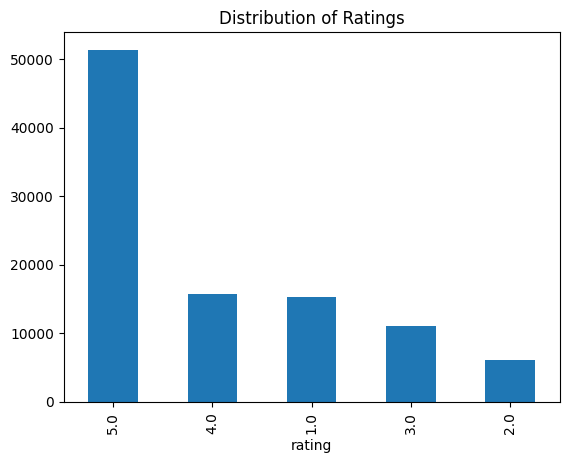

In [21]:
# If the dataset has a rating column or sentiment labels, explore their distribution
df['rating'].value_counts().plot(kind='bar', title='Distribution of Ratings')

In [22]:
sentiment_counts = df["sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100
sentiment_summary = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages.round(2)
})
print(sentiment_summary)

           count  percentage
sentiment                   
positive   63696       63.88
negative   23605       23.67
neutral    12407       12.44


In [23]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word not in stop_words]
    # Stemming
    #stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply to full_text (title+text)
df['clean_full_text'] = df['full_text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
X = df['clean_full_text']
y = df['sentiment']

<pre>
Recommended for large datasets:
Use solver='saga' (supports L1, L2, elasticnet regularization).

Keep penalty='l2' (default).

Use class_weight='balanced' if your classes are imbalanced.

You can also increase max_iter to ensure convergence.
</pre>

In [27]:

# Split your data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(score_func=chi2)),  # Use chi² here
    ('clf', LogisticRegression(
        solver='saga',
        penalty='l2',
        class_weight='balanced',
        random_state=42
    ))
])

# Grid Search Parameters
param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [2000, 3000],  # update key here
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Predictions
y_pred = grid.predict(X_test)

# Results
print("Best TF-IDF max_features:", grid.best_params_['tfidf__max_features'])
print("Best TF-IDF ngram_range:", grid.best_params_['tfidf__ngram_range'])
print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
print("Best C:", grid.best_params_['clf__C'])
print("Best cross-val accuracy:", grid.best_score_)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Test F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


KeyboardInterrupt: 